In [1]:
# packages
import pandas as pd
import pymc as pm
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pytensor import shared

import utils
from utils.stats import * # import r-like distributions functions (rnorm, dnorm, ...)
from utils.plots import init_dag
utils.init() # init plotting styles and warning managements
np.random.seed(8964) # seed

In [ ]:
az.style.use("arviz-doc")
az.rcParams["stats.hdi_prob"] = 0.89
plt.rcParams["figure.dpi"] = 125
plt.rcParams["axes.titleweight"] = "light"
plt.rcParams["font.size"] = 10
plt.rcParams["figure.titlesize"] = 10
plt.rcParams["figure.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.title_fontsize"] = 10
sns.set_context({"font.size": 10,
                 "xtick.labelsize": 10, 
                 "ytick.labelsize": 10, 
                 "axes.labelsize": 10, 
                 "axes.titlesize": 10,
                 "legend.fontsize": 10,
                 "legend.title_fontsize": 10,})

# Chapter 4 Geocentric Models

Claudius Ptolemy built some extremely accurate model for planet motions. The model is basically circles on circles on circles. With enough circles, he could accurately predict the location of a celestial body in the sky. But the model is simply wrong, although in some narrow domain of query it provides accurate answers. This modeling strategy is the same as a Fourier series.

## Keywords
Prior predictive simulation, 



## Section 4.1. Why normal distributions are normal

Consider the Galton's board as an example. McElreath gave a random walk example similar to that. Let's simulate that here. Say 1000 people were to do random walks from the left end of the yard to the right end. And it takes 16 steps. At each left-to-right step, each person either goes up or down by a number between -1 and 1 also.

Learning outcomes:
- 4.1.1 - 4.1.3: when normality comes
- 4.1.4: justifications of using normal distributions

### Code 4.1 (random walks)

In [3]:
random_walks = np.hstack([np.zeros((1000, 1)), runif(-1, 1, size=(1000, 16))]).cumsum(1)
df_random_walks = pd.DataFrame(random_walks).T
df_random_walks.columns = "s" + df_random_walks.columns.astype(str)
df_random_walks["step"] = np.arange(17)
df_random_walks = df_random_walks.melt(id_vars=["step"], value_vars=df_random_walks.columns, value_name="position")

NameError: name 'runif' is not defined

NameError: name 'df_random_walks' is not defined

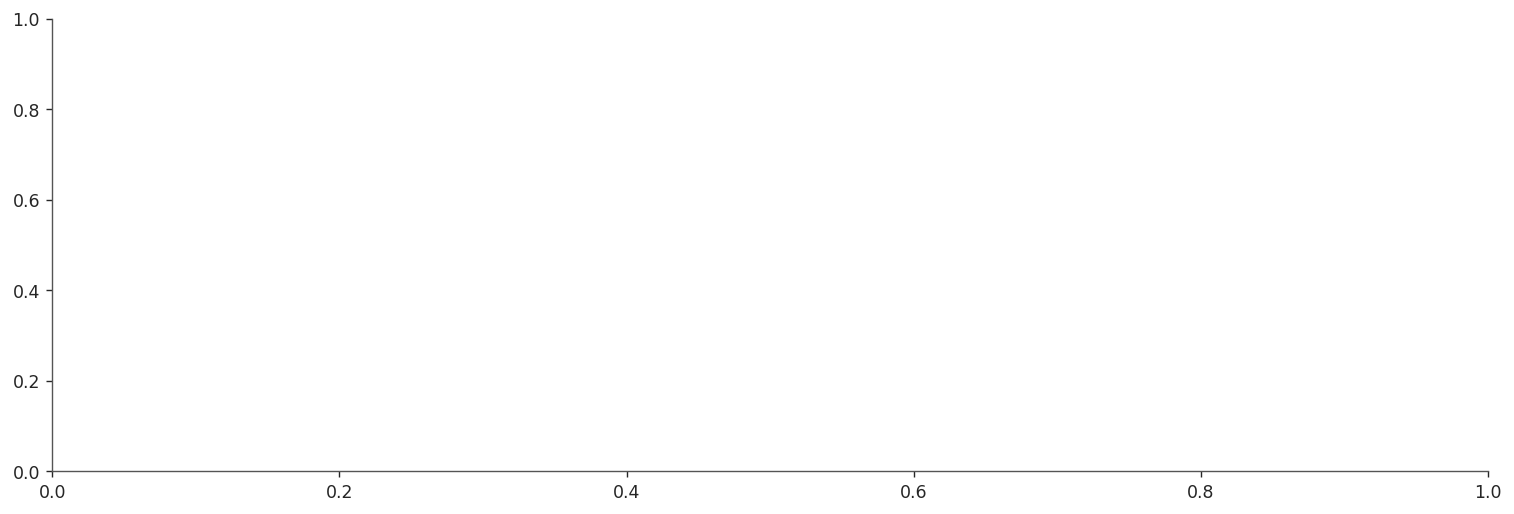

In [4]:
_, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=df_random_walks, x="step", y="position", units="variable", estimator=None, alpha=0.03, ax=ax)
sns.lineplot(data=df_random_walks[df_random_walks.variable == "s0"], x="step", y="position", ax=ax, color="k", linewidth=0.75)
ax.vlines(x=[4, 8, 16], ymin=-8, ymax=8, color="k", linestyles="dashed");

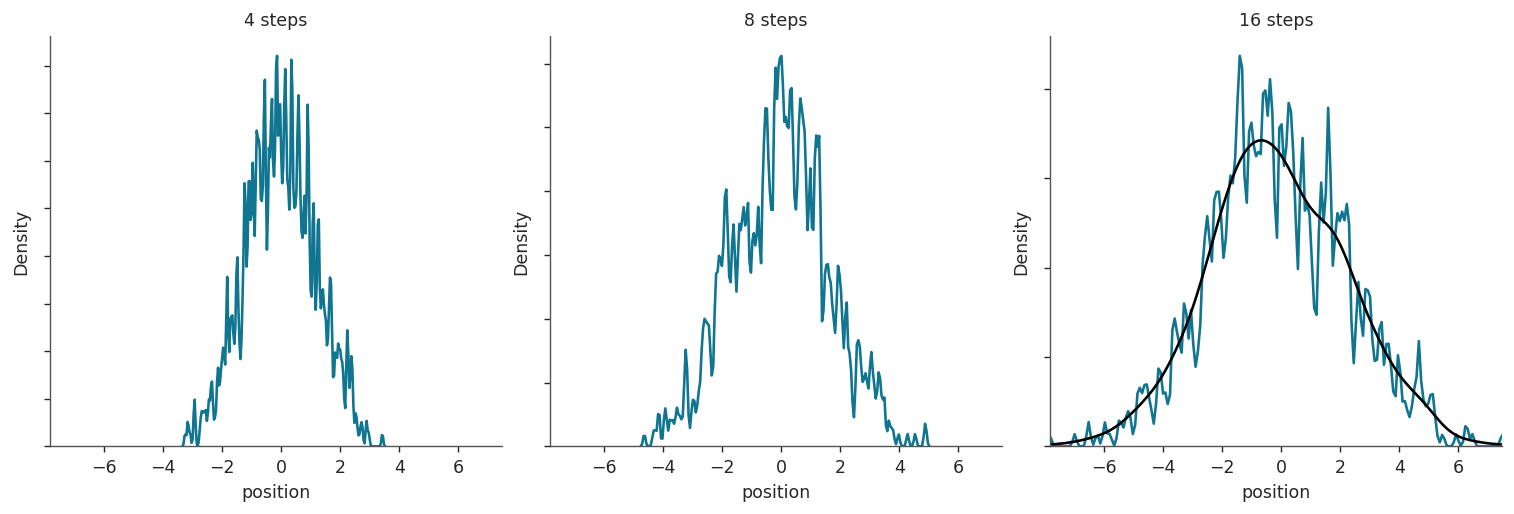

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.kdeplot(random_walks[:, 4], bw_adjust=.1, ax=ax[0])
sns.kdeplot(random_walks[:, 8], bw_adjust=.1, ax=ax[1])
sns.kdeplot(random_walks[:, 16], bw_adjust=.1, ax=ax[2])
sns.kdeplot(random_walks[:, 16], color="k", ax=ax[2])
ax[0].set(title="4 steps")
ax[1].set(title="8 steps")
ax[2].set(title="16 steps")
plt.setp(ax, xlabel="position", xlim=[random_walks.min(), random_walks.max()], yticklabels=[]);

If you add together independent random values from the same distribution, you always get a normal random variable. The underlying distribution of each value can be nearly anything, but the convergence will happen, sometimes slowly. 

### Code 4.2 (normality by multiplication)

Here's another to get a normal distribution.

In [7]:
runif(1, 1.1, size=12).cumprod()

array([1.01035859, 1.02872923, 1.0353434 , 1.08229546, 1.17702377,
       1.21612156, 1.29179795, 1.29738992, 1.31703193, 1.32098232,
       1.39445127, 1.4862321 ])

### Code 4.3 (cont'd)

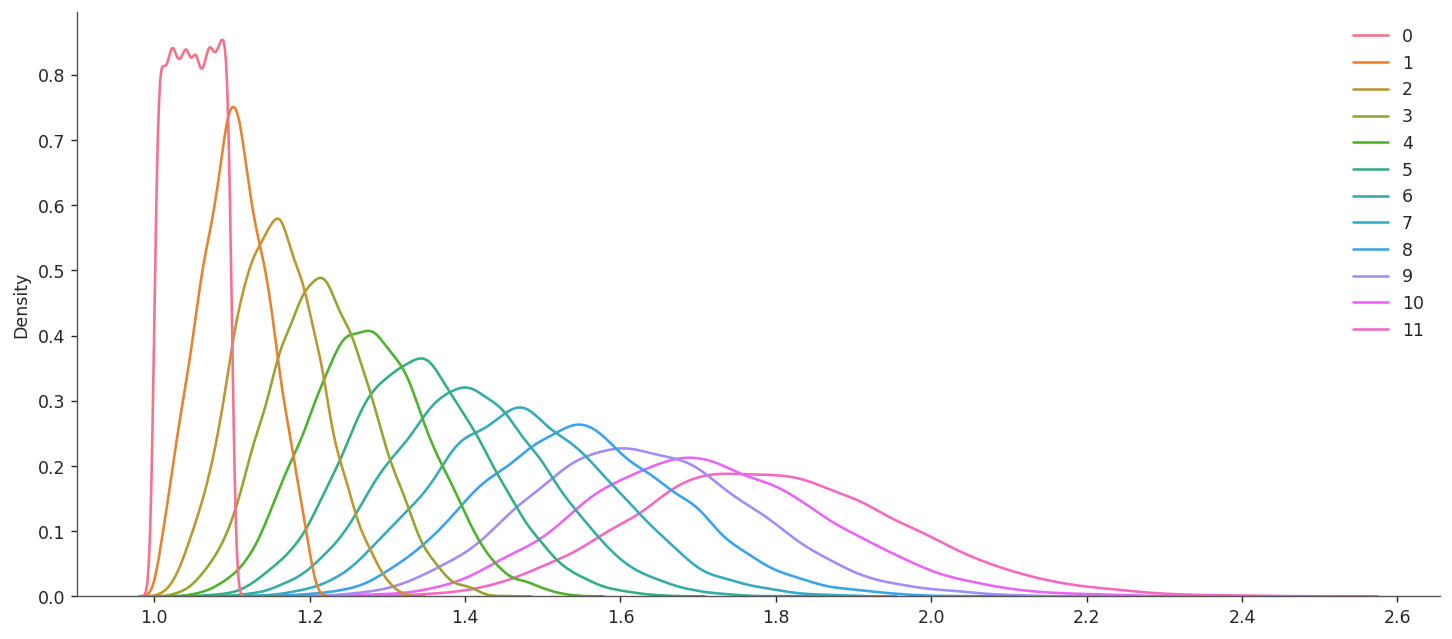

In [8]:
growth = runif(1, 1.1, size=(int(1e4), 12)).cumprod(1)
df_growth = pd.DataFrame(growth.T)
sns.kdeplot(growth);

### Code 4.4 (cont'd)

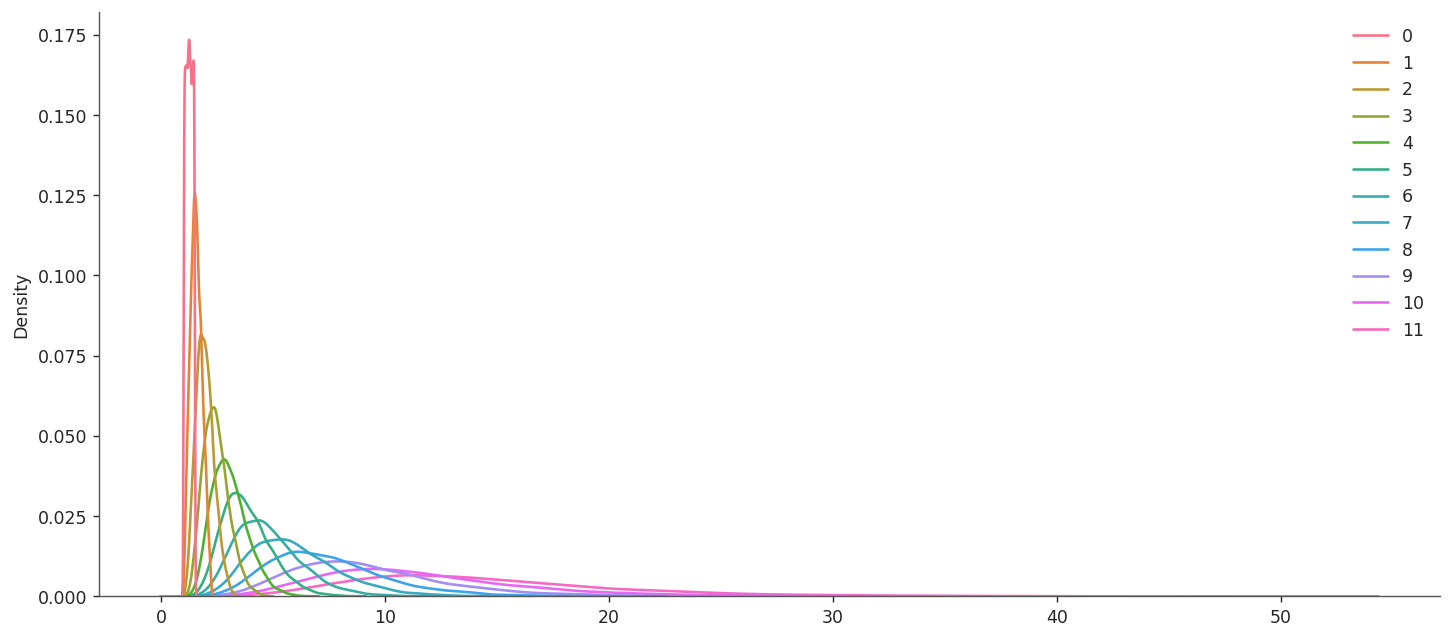

In [9]:
growth = runif(1, 1.5, size=(int(1e4), 12)).cumprod(1)
df_growth = pd.DataFrame(growth.T)
sns.kdeplot(growth);

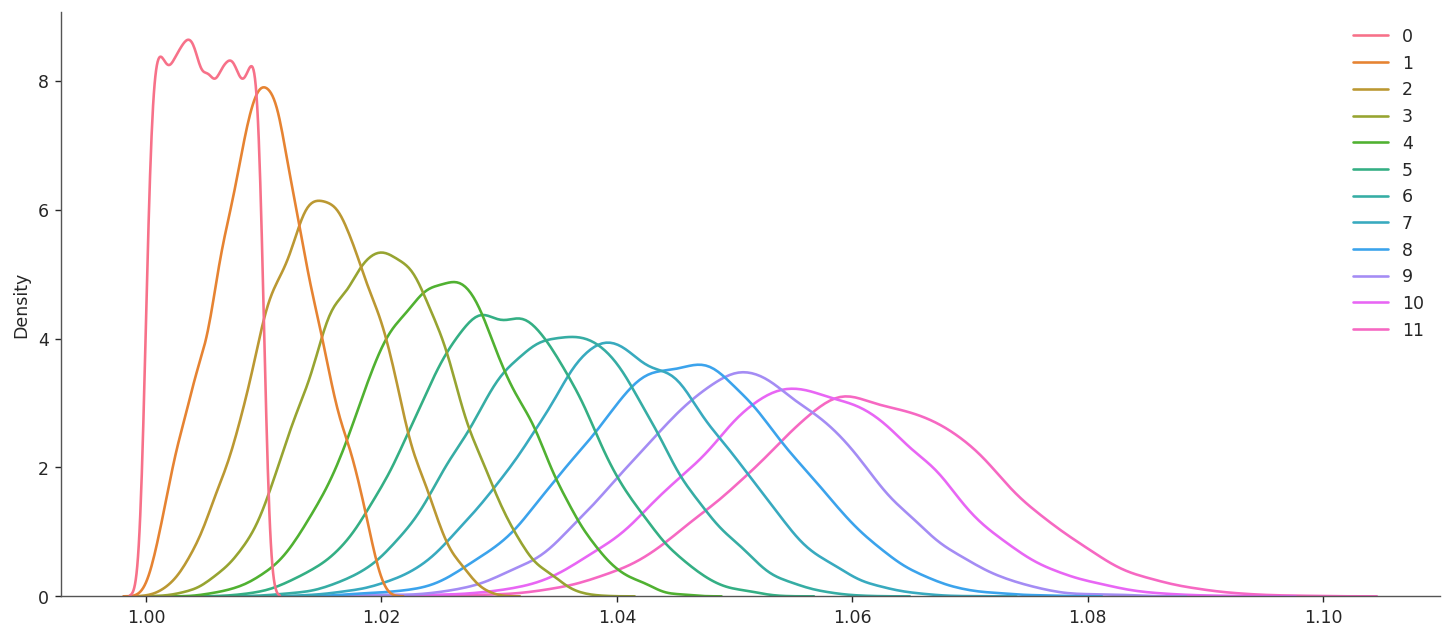

In [10]:
growth = runif(1, 1.01, size=(int(1e4), 12)).cumprod(1)
df_growth = pd.DataFrame(growth.T)
sns.kdeplot(growth);

The smaller the maximum multiplicative factor can be, the closer the curve is to the bell shape. But wait, large multiplicative factors do tend towards a log normal distribution.

### Code 4.5 (log normal growth)

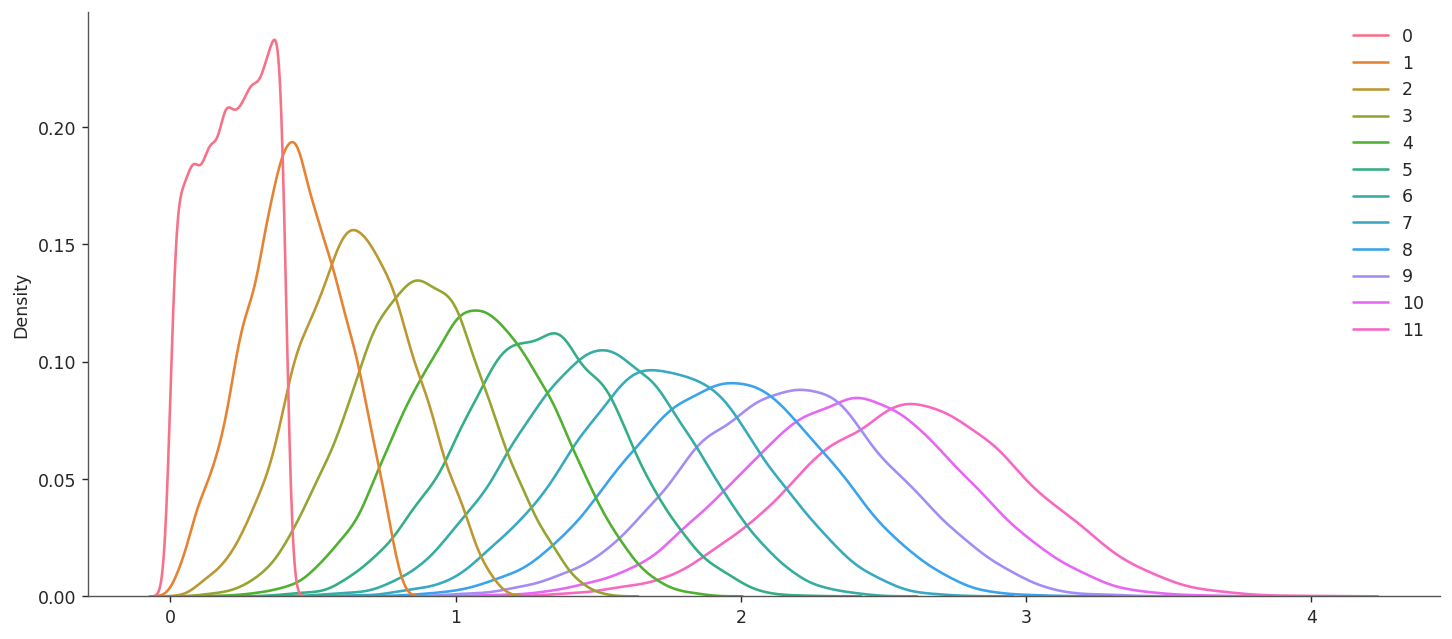

In [11]:
log_big = np.log(runif(1, 1.5, size=(int(1e4), 12))).cumsum(1)
log_big = pd.DataFrame(log_big)
sns.kdeplot(log_big);

(4.1.4) The justifications for using normal distributions:
1. _Ontological justification_. Whenever there are processes that add together fluctuations, the fluctuations themselves might become less important than their mean and spread. Doing this often prevents us from knowing more about the underlying fluctuations. In a word, Gaussians are just part of the nature.
2. _Epistemological justification_. Gaussian distributions are the most natural expression of our state of ignorance, besides knowing the mean and the variance of the distribution. We will look into this more in later chapters when we talk about information theory and maximun entropy (maxent).

But many natural and unnatural processes have much heavier tails. For example, stock prices can look Gaussian in the short term, but extreme shocks during a long time window make the Gaussian model look foolish. 

An alternative parametrization of Gaussians uses $\tau = 1/\sigma^2$ instead of $\sigma$, called the "precision". 

## Section 4.2. A language for describing models

McElreath tends to refer to data as observed variables, and parameters as unobserved variables. So he makes that point here. Another point is that we should unify our language of defining our statistical models to a form that's similar to how stan or PyMC defines them with code. That way, you do not need to memorize the meaning of crazy terms like _heteroscedasticity_, you can just read the assumptions from your model definition.

### Code 4.6 (grid approximation)
Model:
$$W \sim \text{Binomial}(N, p)$$
$$p \sim \text{Uniform}(0, 1)$$

In [195]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = dbinom(w, n, p_grid)*dunif(p_grid, 0, 1)
posterior /= posterior.sum()

## Section 4.3. Gaussian model of height

We want our Bayesian model to rank all combinations of means and variances by the posterior plausibility.

### Code 4.7 (read Howell1 data)

In [2]:
d = pd.read_csv("../Data/Howell1.csv", delimiter=";")

## Code 4.8 (cont'd)

In [3]:
d

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


### Code 4.9 (cont'd)

In [4]:
def precis(df):
    des = df.describe(percentiles=[.055, .945])
    return des[des.index.isin(["mean", "std", "5.5%", "94.5%"])].T.round(2)

precis(d)

,mean,std,5.5%,94.5%
height,138.26,27.60,81.11,165.74
weight,35.61,14.72,9.36,54.50
age,29.34,20.75,1.00,66.13
male,0.47,0.50,0.00,1.00


We are just studying the height column for now.

### Code 4.10 (cont'd)

In [5]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11 (cont'd)

Let's now just ignore the correlation between age and height that is often present in non-adults, by simplying filtering out the non-adults data points.

In [6]:
d2 = d[d.age >= 18]

Plot a density plot for the height and see if it looks like a bell curve. The answer is yes. This may be because height is a sum of many small growth factors. But gawking at the data to decide how to model them is usually not a good idea. 

**Rethinking: I.I.D.**. This assumption is hardly true in a physical sense. For the heights in the Howell data, it could be that some of these individuals are from the same families.

But the I.I.D. assumption doesn't need to seem awkward. It is an epistemological assumption, rather than an ontological one. It's only about how our models represent their uncertainty. Jaynes called this the [mind projection fallacy](https://en.wikipedia.org/wiki/Mind_projection_fallacy), when people confuse epistemological claims with ontological claims.

Let's build a model for the adult heights.
$$h_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu \sim \text{Normal}(178, 20)$$
$$\sigma \sim \text{Uniform}(0, 50)$$

Why 178 cm? McElreath is 178 cm tall. And 178 +- 40 encompasses a wide range of plausible human mean heights. Everybody knows something about human heights and thus can set a reasonable vague prior like this. But in many problems, using prior information is more subtle since parameters do not always have physical meaning. Whatever the prior, it's good to plot your priors for confirming what your assumptions are.

### Code 4.12 (plot prior of the mean heights)

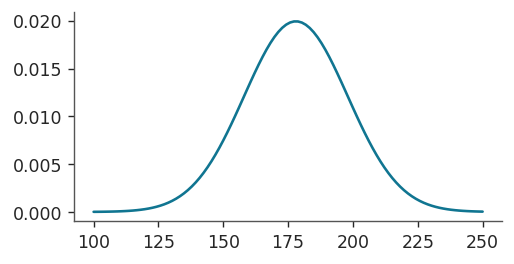

In [167]:
_, ax = plt.subplots(figsize=(4, 2))
x = np.linspace(100, 250, 100)
ax.plot(x, dnorm(x, 178, 20));

### Code 4.13 (plot prior of the height variance)

How should we pick the upper bound? A standard deviation of 50 cm would imply that 95% of individual heights lie within 100cm of the average height (small world numbers). That's a very large range.

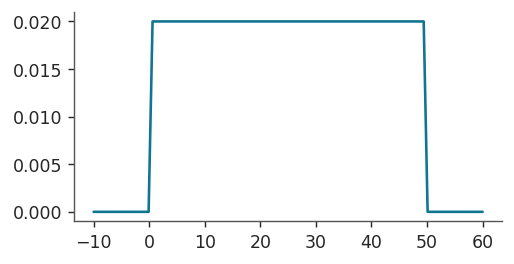

In [168]:
_, ax = plt.subplots(figsize=(4, 2))
x = np.linspace(-10, 60, 100)
ax.plot(x, dunif(x, 0, 50));

### Code 4.14

It also helps to see what our priors imply about the simulated individual heights. (**prior predictive simulation**)

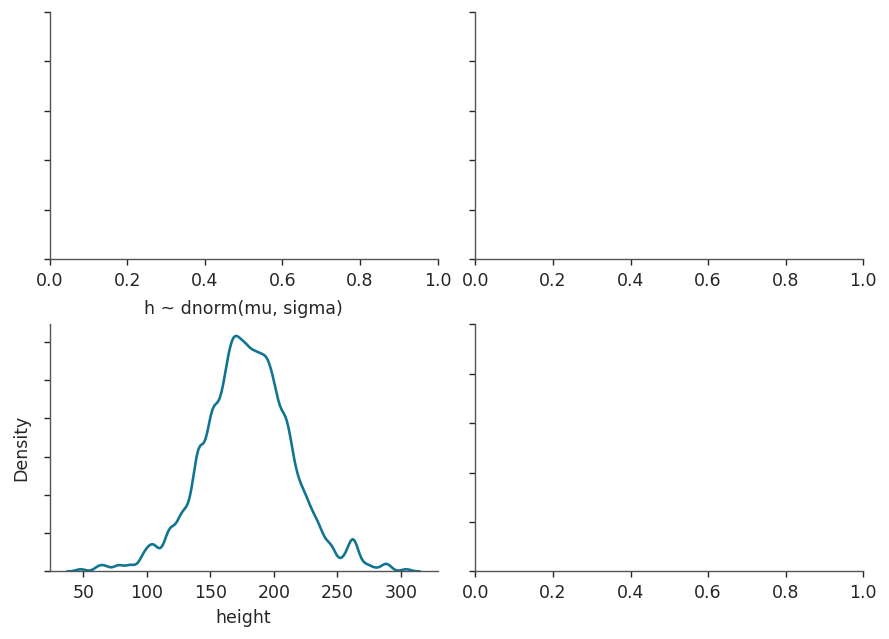

In [172]:
n_samples = 1000
sample_mu = rnorm(178, 20, n_samples)
sample_sigma = runif(0, 50, n_samples)
prior_h = rnorm(sample_mu, sample_sigma, n_samples)

fig, ax = plt.subplots(2, 2, figsize=(7, 5))
plt.setp(ax, yticklabels=[])
sns.kdeplot(prior_h, bw_adjust=.4, ax=ax[1, 0])
ax[1, 0].set(title="h ~ dnorm(mu, sigma)", xlabel="height");

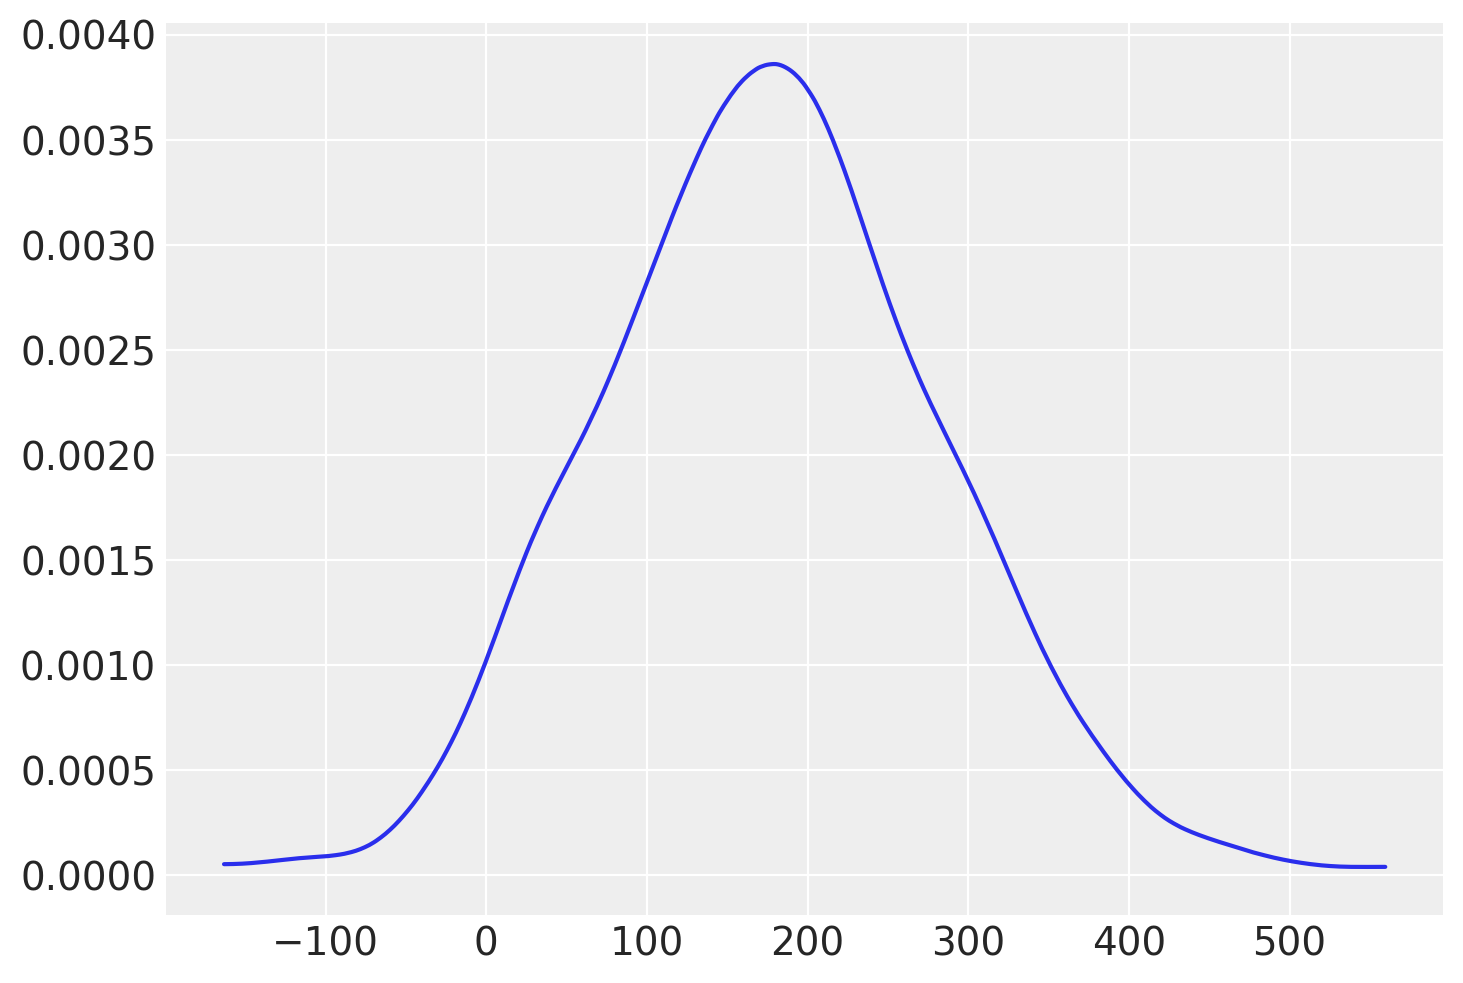

In [17]:
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h);

In [6]:
with pm.Model() as height_model:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    
with height_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [26]:
az.summary(trace, round_to=2, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.60,0.42,153.96,155.28
sigma,7.77,0.29,7.30,8.24


In [7]:
az.summary(trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.612,0.410,153.919,155.220,0.007,0.005,3617.0,2790.0,1.0
sigma,7.773,0.298,7.293,8.228,0.005,0.004,3629.0,2831.0,1.0


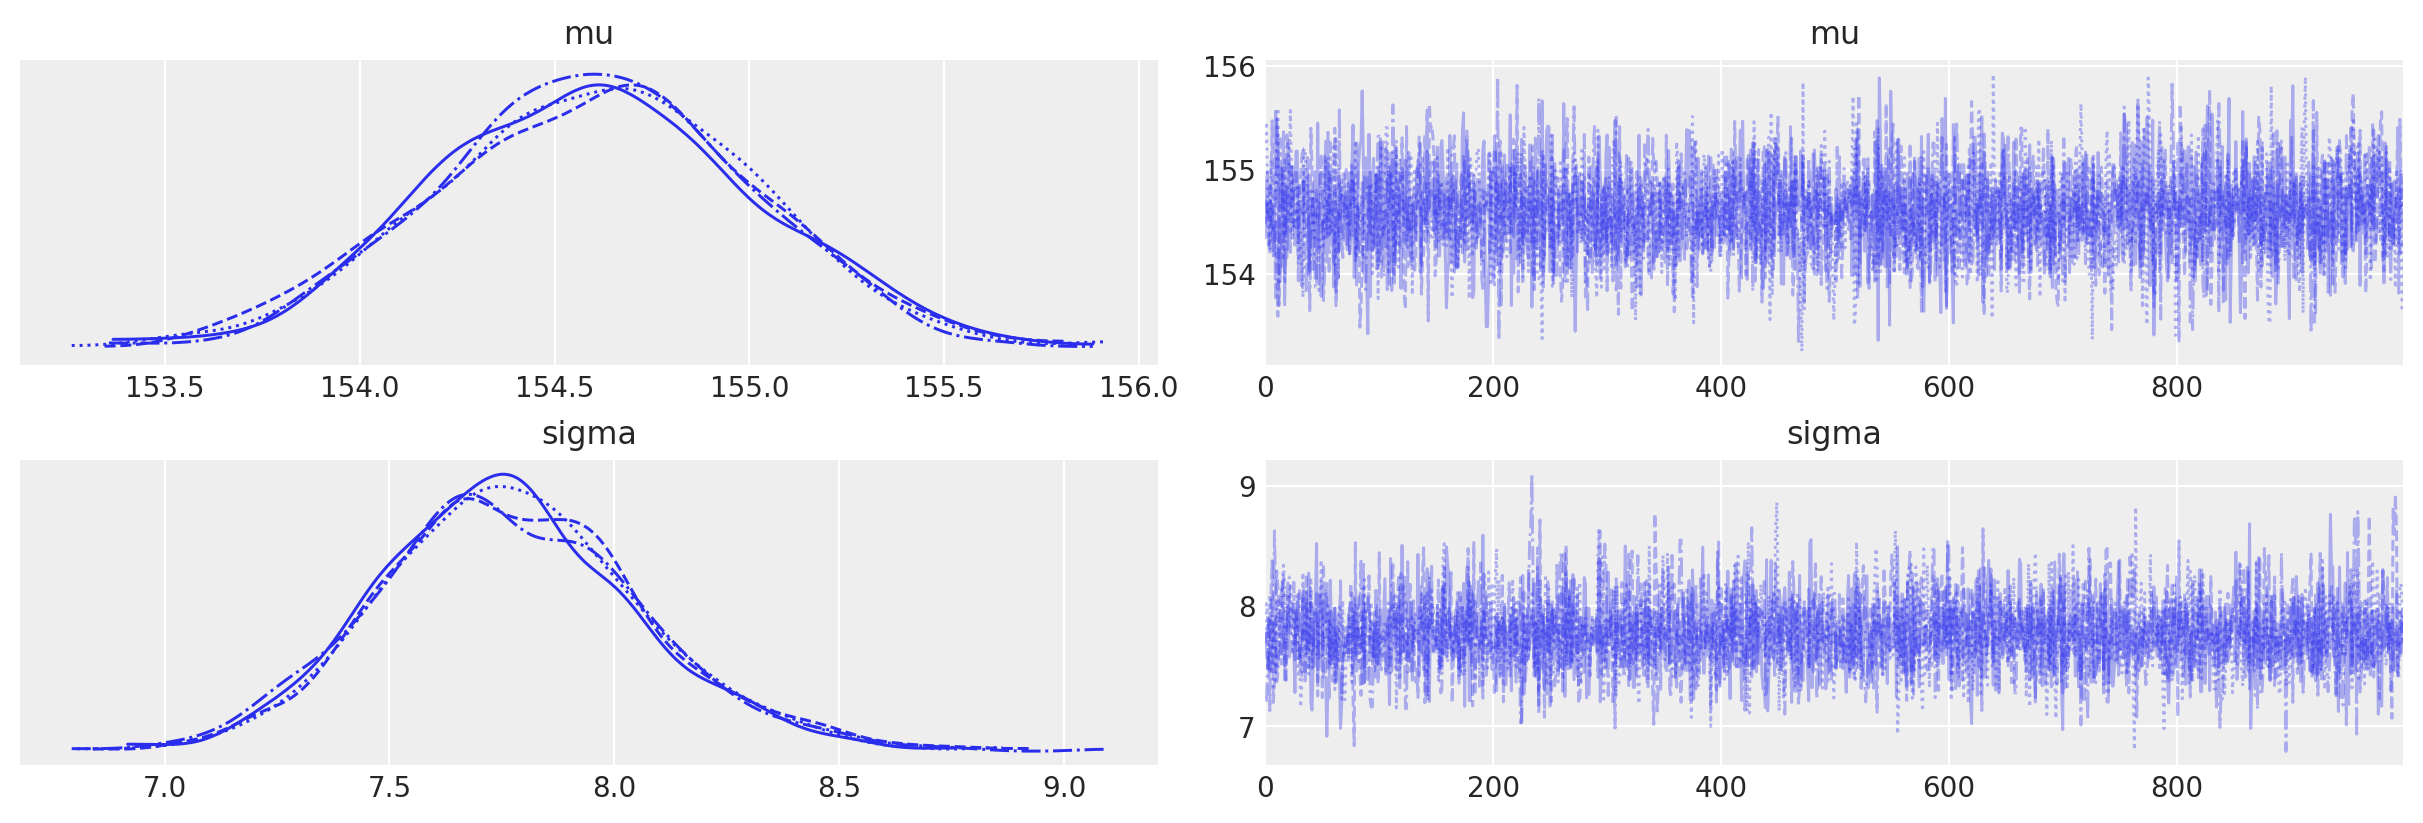

In [30]:
az.plot_trace(trace);

In [32]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_1 = pm.sample(1000, tune=1000)

/tmp/ipykernel_1425/3363333656.py:2: FutureWarning: The `testval` argument is deprecated; use `initval`.
  mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
/tmp/ipykernel_1425/3363333656.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [33]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    
with m4_2:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [34]:
trace_df = az.extract_dataset(trace).to_dataframe()
trace_df.cov()

/tmp/ipykernel_1425/1507440975.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_df = az.extract_dataset(trace).to_dataframe()


,mu,sigma,chain,draw
mu,0.009864,0.007757,0.002845,-0.544664
sigma,0.007757,0.922159,0.027879,-7.137681
chain,0.002845,0.027879,1.250313,0.000000
draw,-0.544664,-7.137681,0.000000,83354.088522


In [39]:
trace_df.sigma[0]

draw
0      25.027192
1      24.839433
2      25.398160
3      23.210878
4      24.642703
         ...    
995    24.269006
996    24.817535
997    24.515952
998    25.093714
999    24.880626
Name: sigma, Length: 1000, dtype: float64

In [8]:
xbar = d2.weight.mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    mu = a + b*(d2.weight - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    trace_4_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
az.summary(trace_4_3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,154.597,0.269,154.175,155.035,0.004,0.003,5689.0,3032.0,1.0
b,0.903,0.044,0.835,0.973,0.001,0.000,6258.0,3187.0,1.0
sigma,5.102,0.195,4.808,5.422,0.003,0.002,5418.0,3168.0,1.0


In [17]:
trace_df = az.extract(trace_4_3).to_dataframe()
trace_df[["a", "b", "sigma"]].cov()

,a,b,sigma
a,0.074389,0.000115,0.000728
b,0.000115,0.001857,-0.000172
sigma,0.000728,-0.000172,0.037195


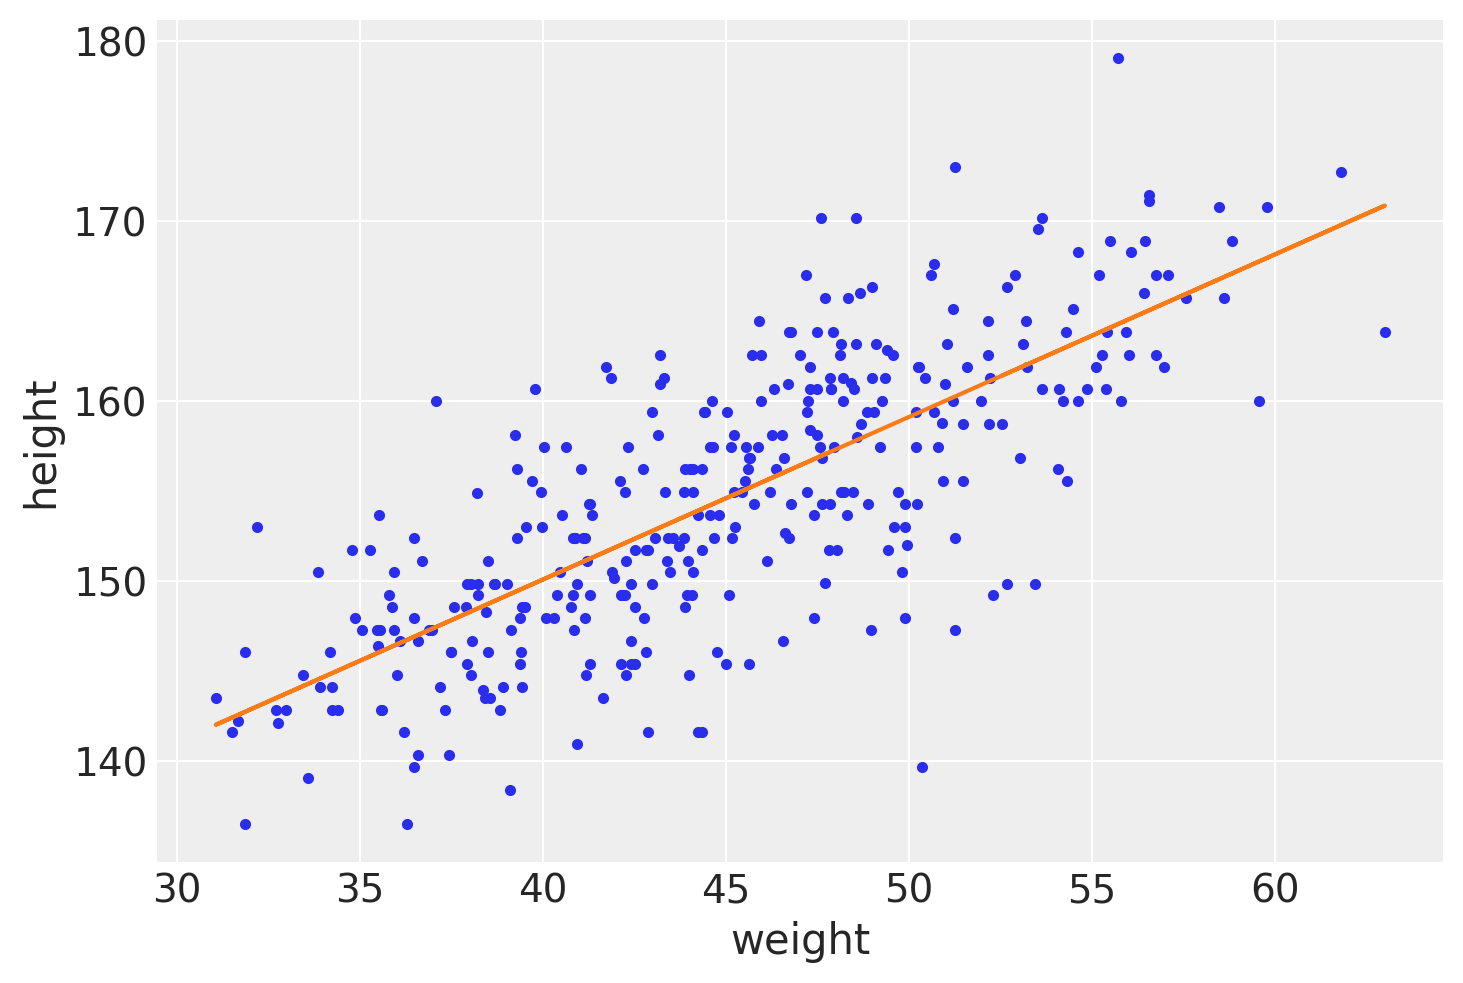

In [20]:
plt.plot(d2.weight, d2.height, ".")
plt.plot(
    d2.weight,
    trace_4_3.posterior["a"].mean().item(0)
    + trace_4_3.posterior["b"].mean().item(0) * (d2.weight - xbar),
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

In [57]:
n = 175
dn = d2.iloc[:n, :]
xbar = dn.weight.mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    mu = pm.Deterministic("mu", a + b*(dn.weight - xbar))
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=dn.height)
    trace_4_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


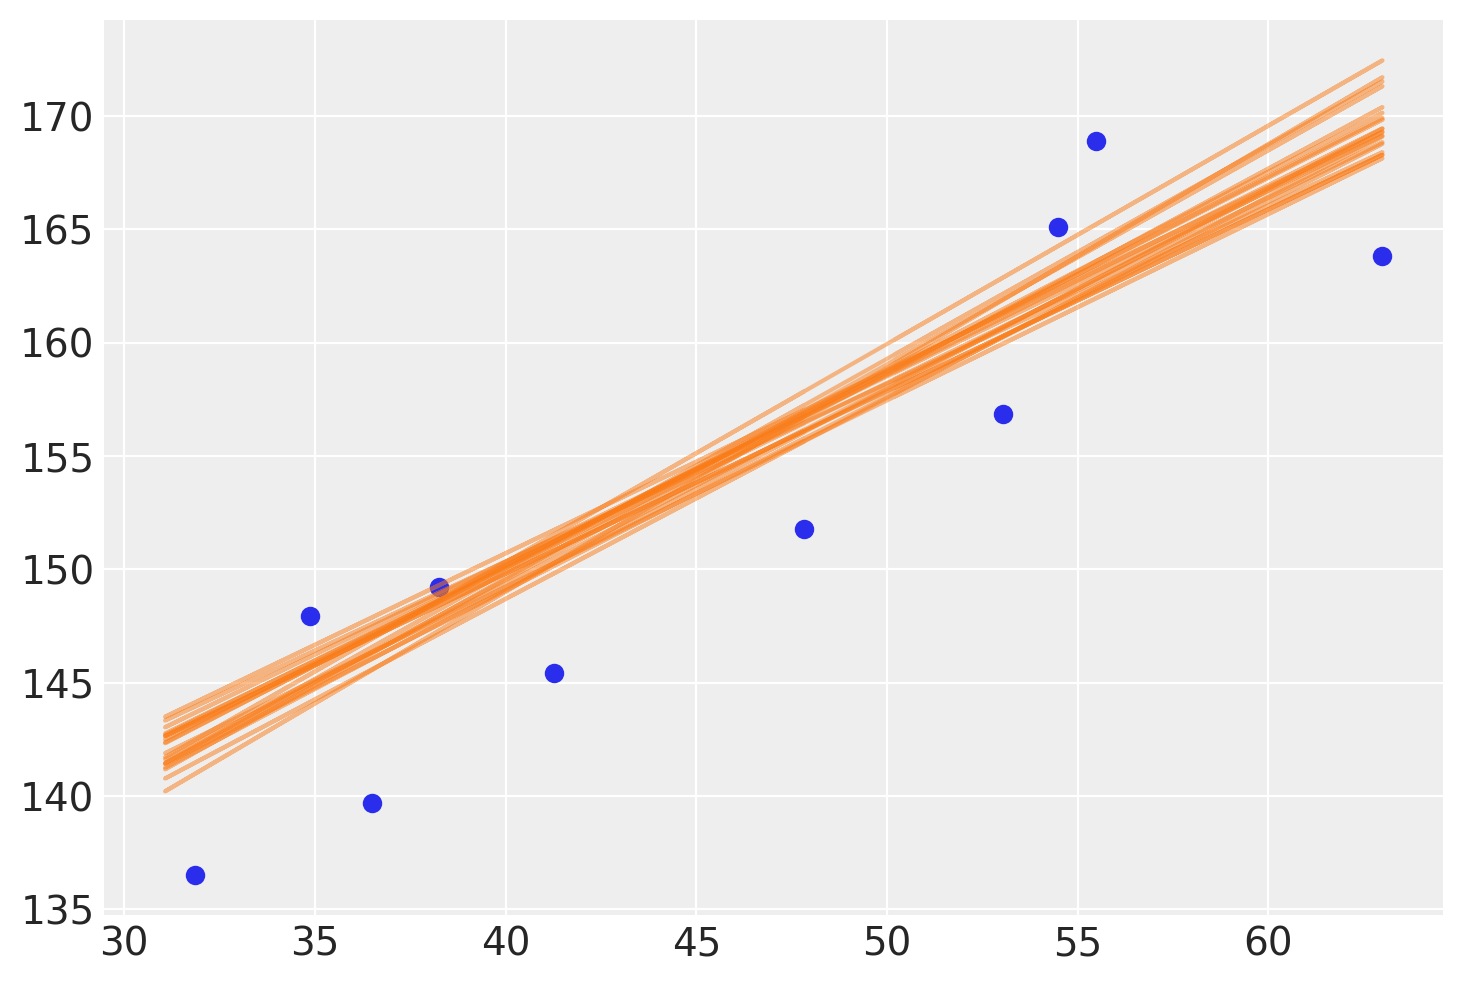

In [59]:
plt.plot(dn.weight[:10], dn.height[:10], "C0o")

trace_df = az.extract(trace_4_3)
n_samples = trace_df.sizes["sample"]
height_rng = np.random.default_rng(2971)
idxs = height_rng.integers(n_samples, size=20)

for idx in idxs:
    plt.plot(
        dn.weight, trace_df["mu"][:, idx],
        "C1-",
        alpha=0.5,
    )

In [54]:
trace_df = az.extract(trace_4_3) # back to full data model
mu_at_50 = trace_df["a"] + trace_df["b"]*(50 - d2.weight.mean())

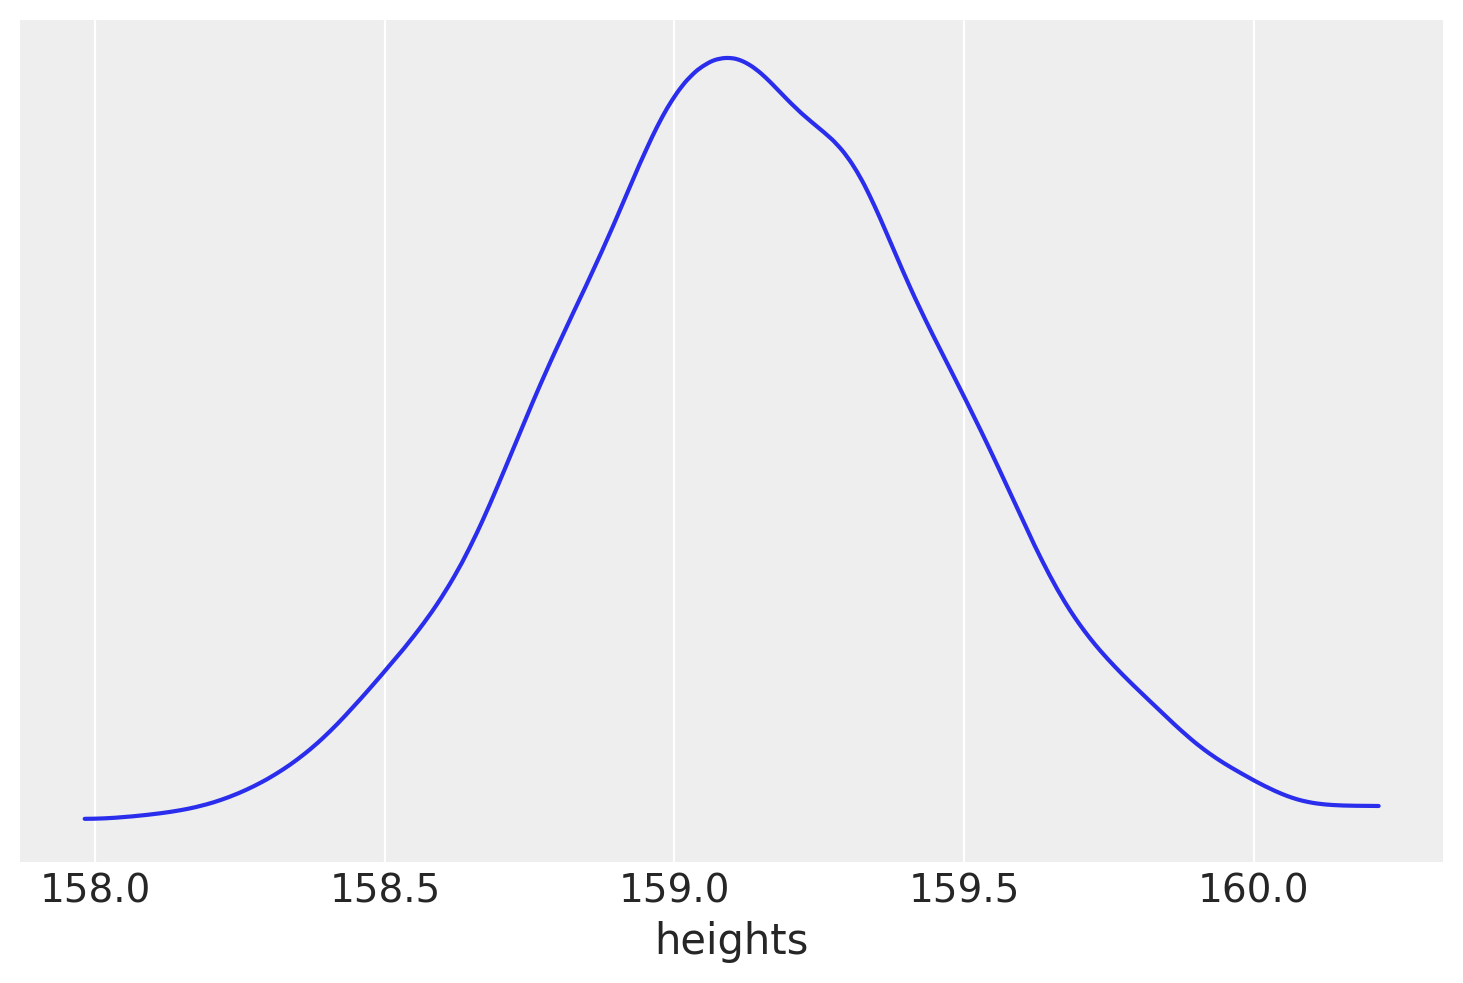

In [56]:
az.plot_kde(mu_at_50.values)
plt.xlabel("heights")
plt.yticks([]);

In [125]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
nb_samples = trace_df.sizes["sample"]
trace_4_3_thinned = trace_df#.isel(sample=range(0, nb_samples, 10))
nb_samples_thinned = trace_4_3_thinned.sizes["sample"]

mu_pred = np.zeros((len(weight_seq), nb_samples_thinned))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - d2.weight.mean())

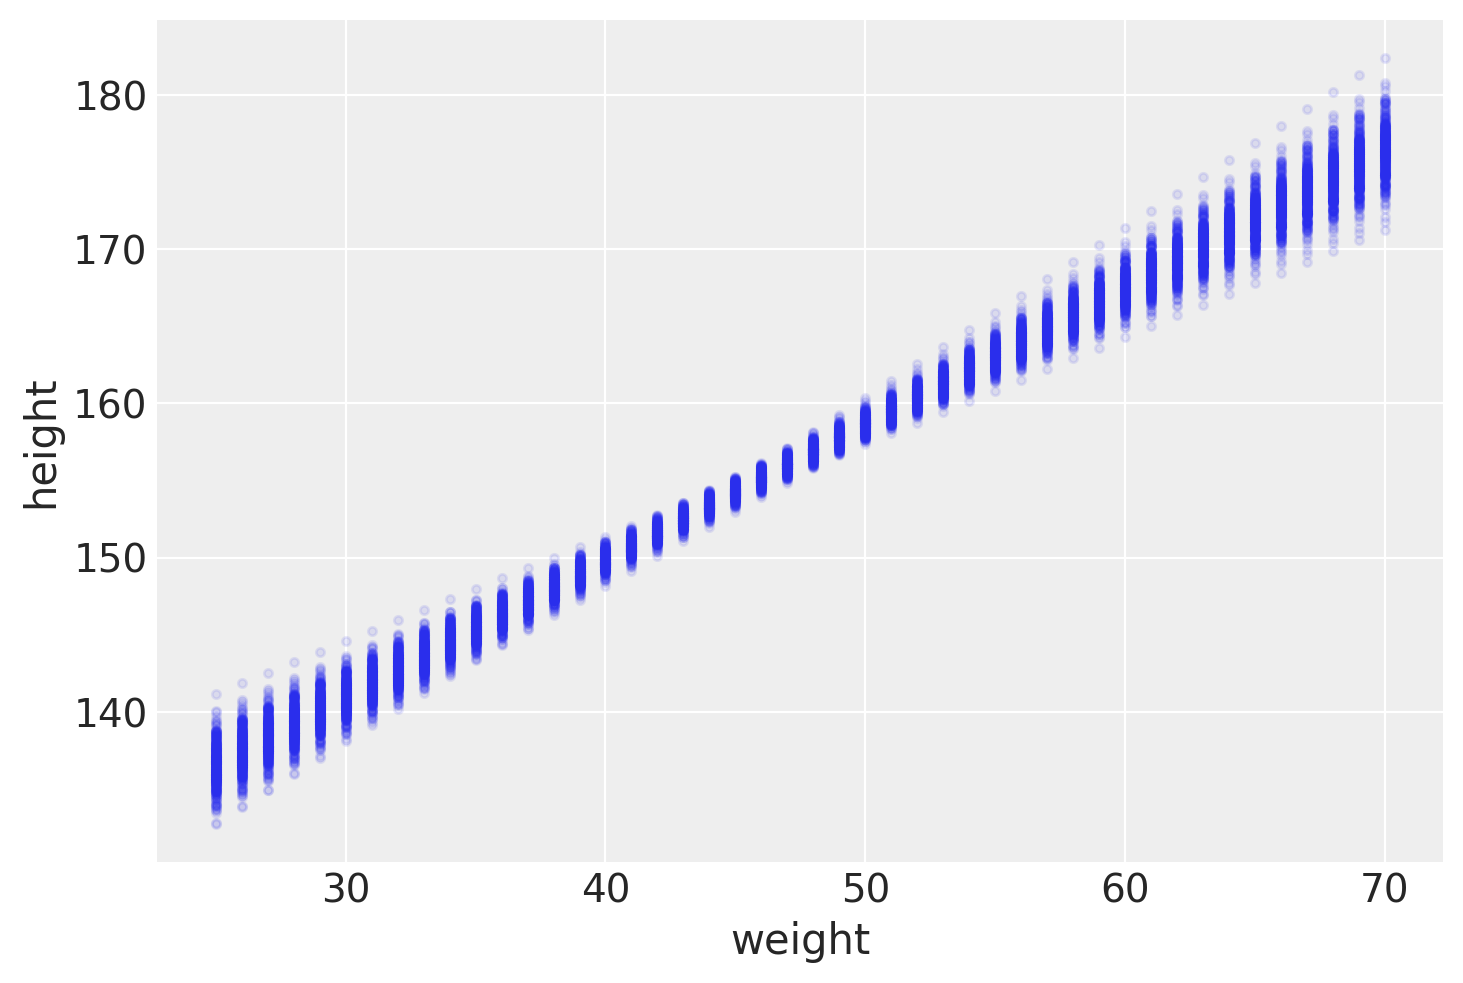

In [61]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

In [62]:
mu_mean = mu_pred.mean(1)
mu_hdi = az.hdi(mu_pred.T)

/tmp/ipykernel_35/2684262116.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mu_pred.T)


/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


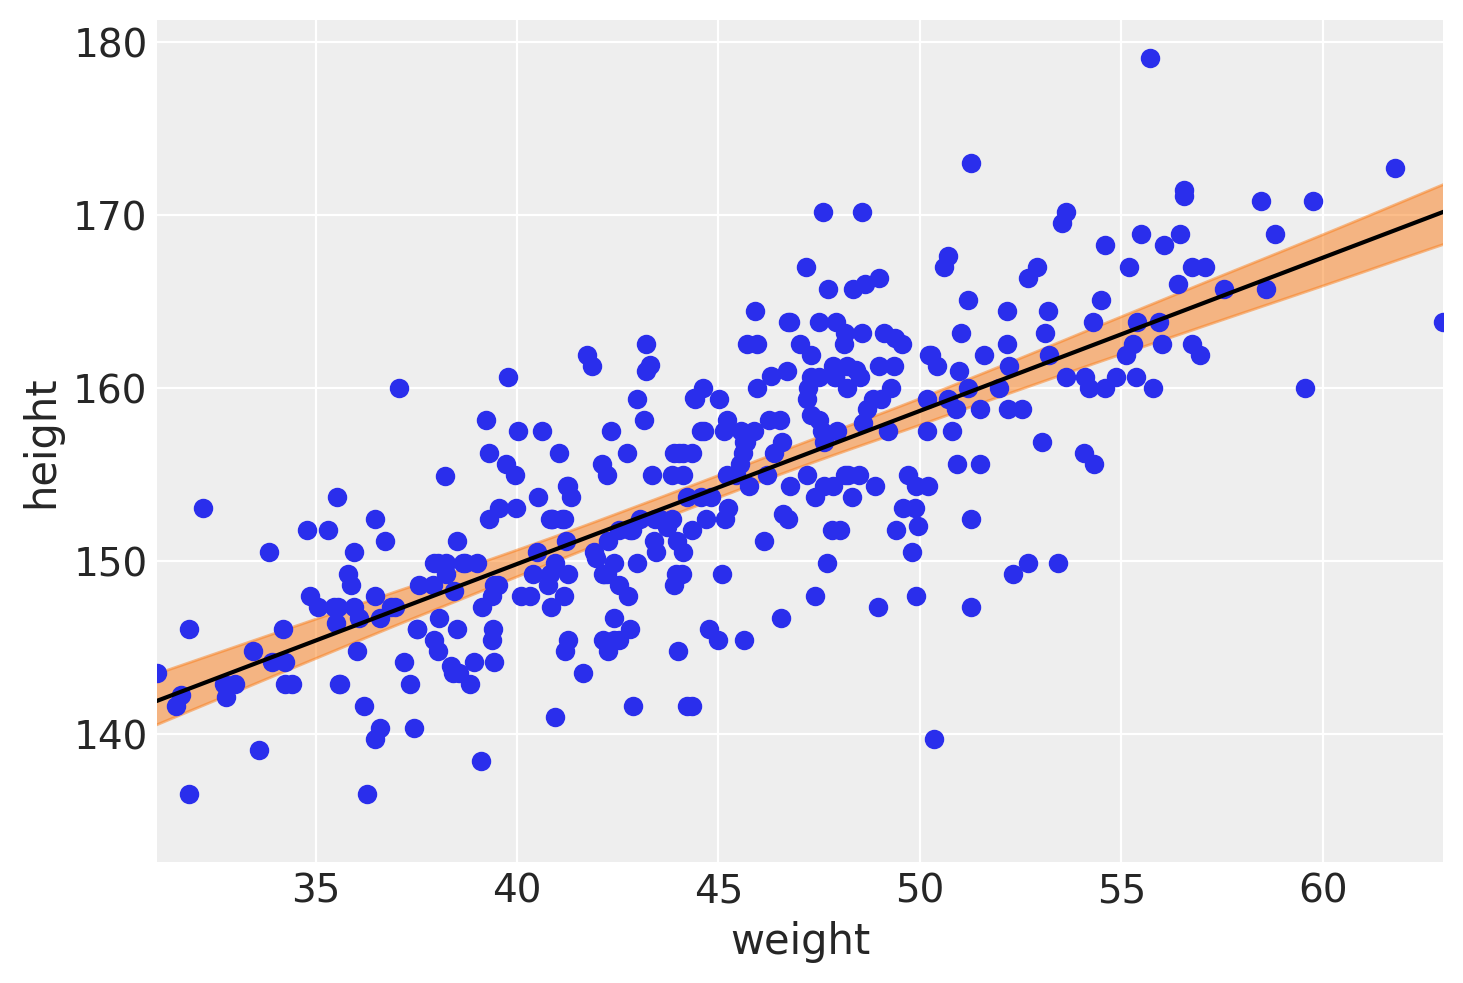

In [69]:
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

In [74]:
trace_4_3

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [122]:
thinned_idata = trace_4_3.sel(draw=slice(None, None, 100))
#thinned_idata = trace_4_3
with m4_3:
    height_pred = pm.sample_posterior_predictive(thinned_idata)

Sampling: [height]


In [123]:
height_pred_hdi = az.hdi(height_pred.posterior_predictive["height"])

/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


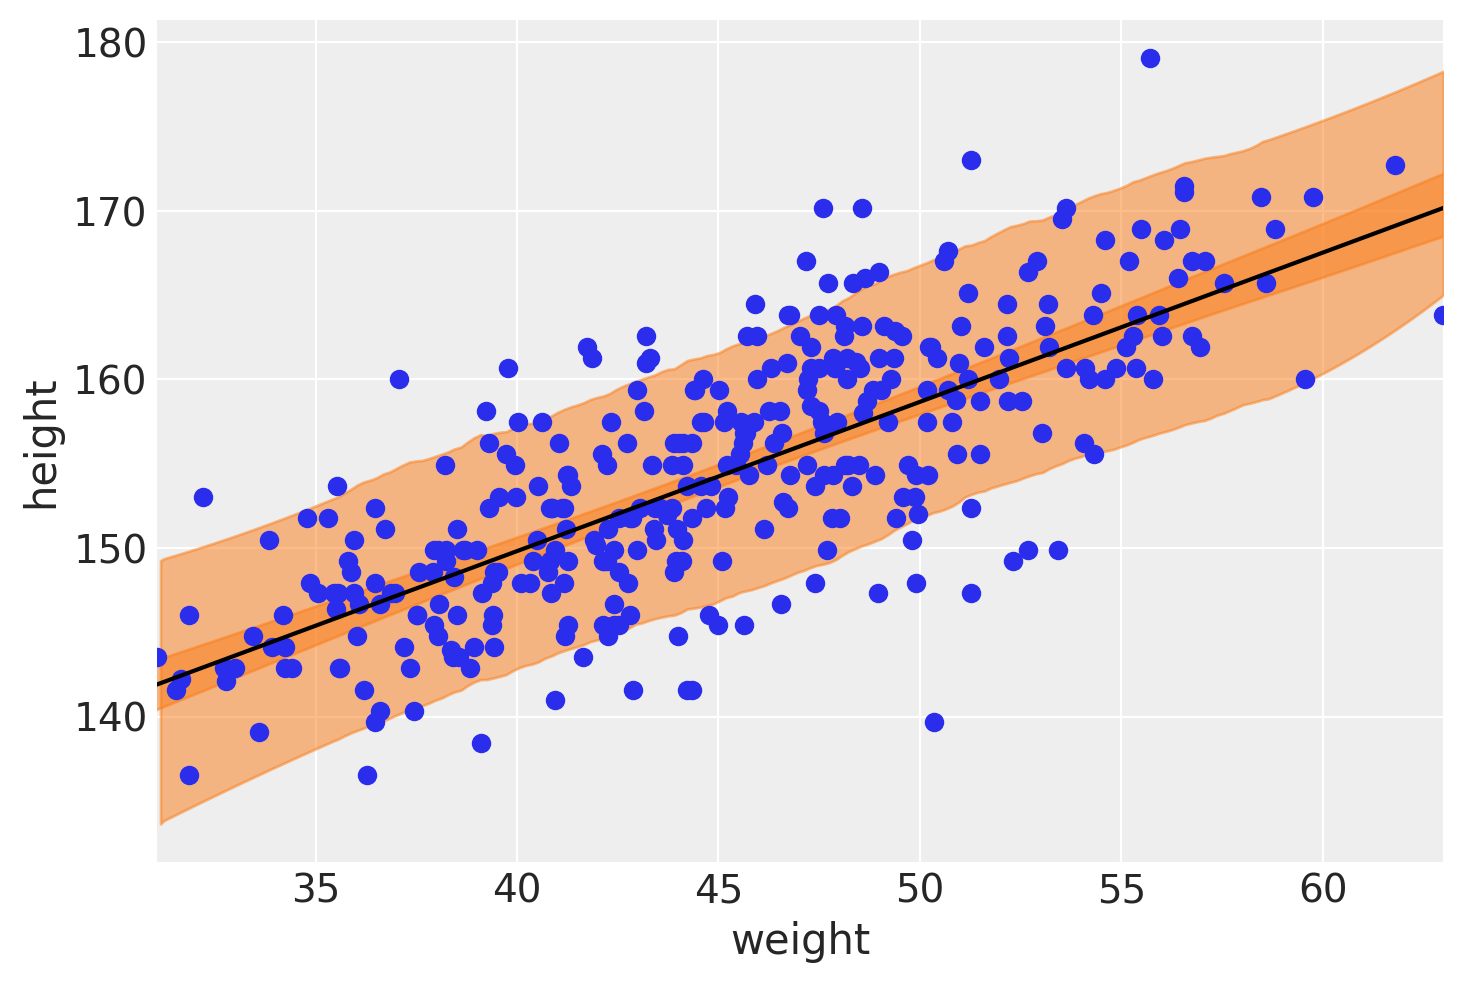

In [126]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred.posterior_predictive["height"], ax=ax)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

In [128]:
data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [ ]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

In [2]:
%load_ext watermark
%watermark -v -iv -p scipy,daft,pytensor -u -n -t

Last updated: Sun Apr 09 2023 11:08:24

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.12.0

scipy   : 1.10.1
daft    : 0.1.2
pytensor: 2.10.1

arviz     : 0.15.1
matplotlib: 3.7.1
seaborn   : 0.12.2
numpy     : 1.24.2
pandas    : 1.5.3
xarray    : 2023.3.0
pymc      : 5.2.0

